## Paquetes

In [1]:
import pandas as pd
import openpyxl
from tqdm import tqdm
import unidecode
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
import warnings
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import math
from operator import itemgetter

import unidecode
import string
import re
from fuzzywuzzy import fuzz
import os
import traceback
from scipy.stats import ttest_ind

import rddensity
from rdrobust import rdrobust,rdbwselect,rdplot
import statsmodels.api as sm
import matplotlib.pyplot as plt

import seaborn as sns
import scipy.stats as stats
from scipy.stats import norm

In [2]:
#PRUEBA GRÁFICA PARA CADA AÑO, 20111, 15 Y 19

#PARA CADA AÑO, VER QUE PASA EN LOS t's siguientes con la discontinua
#HACER GRAFICA DE DISPESIÓN
#CORRER REGRESIÓN PARA CERO DERIVADA, KERNEL TRIANGULAR, KERNEL UNIFORME, P1 Y P2
#CORRER REGRESIÓN PARA PRIMER DERIVADA, KERNEL TRIANGULAR, KERNEL UNIFORME, P1 Y P2


#DIF EN DIF PARA 2011

## Procesamiento de data electoral

In [541]:
################################################################################################################
#PARAMETROS
año_t0 = 2011      #PERIODO DE TRIUNFO EN PRIMER ELECCIÓN
año_t1 = año_t0 + 4 #PERIODO DE REPETICIÓN O NO REPETICIÓN
años_ev = [año_t1+1, año_t1+2, año_t1+3, año_t1+4] #AÑOS CONSIGUIENTES DESPUES DE LA REPETICIÓN

In [542]:
data_electoral_procesada = "OUT_1_DATA_ELECTORAL_PROCESADA"
data_electoral_raw = "INPUT_1_DATA_ELECTORAL"
partidos = pd.read_excel(f"{data_electoral_procesada}//Partidos_Electorales_Long.xlsx")

In [543]:
concejo = pd.read_stata(f"INPUT_1_DATA_ELECTORAL/Concejos/{año_t1}_concejo.dta")
concejoc = concejo.groupby(["codmpio", "codigo_partido"])[["curules"]].sum().reset_index()
curules_totales = concejo.groupby(["codmpio"])[["curules"]].sum().reset_index(); curules_totales.columns = ["codmpio", "curules_totales"]
concejoc = concejoc.merge(curules_totales, "left", "codmpio")
concejoc["curules_share"] = concejoc["curules"]/concejoc["curules_totales"]
partidos_consejoc = partidos.merge(concejoc, "left", "codigo_partido")

In [544]:
carpeta1 = "OUT_2_TESTS"
if not os.path.exists(carpeta1):
    os.makedirs(carpeta1)

### Procesamiento según los parámetros

In [567]:
################################################################################################################
# PROCESAMIENTO DE LOS DATOS ELECTORALES

################################################################################################################
# PRIMER PERIODO
dfg = pd.read_stata(f"{data_electoral_raw}/Alcaldías/{año_t0}_alcaldia.dta")
df = dfg.copy()

nulos = df[["codmpio", "codigo_lista"]]
nulos = nulos[nulos["codigo_lista"]==998]
nulos.columns = ["codmpio", "votos_nulos"]
df = df.sort_values(by = ["codmpio", "votos"], ascending= [True, False])
df = pd.merge(df, nulos, "left", "codmpio")

df["votos_porcentaje"] = df["votos"]/(df["censoe_total"]-df["votos_nulos"])
df[f"votos_segundo"] = df.groupby(["codmpio"]).shift(-1)["votos_porcentaje"]

df = df[df.curules == 1]
df = df.rename(columns = {"votos_porcentaje": "votos_primero"})

df = df[['ano', 'municipio', 'codmpio', 'codigo_partido', 'primer_apellido', 'votos_primero', 'votos_segundo']]
dff = df.copy()
dff = dff.merge(partidos, "left", "codigo_partido")

dff.columns = [col if col in ['codmpio', 'municipio', 'miembros_code'] else f'{col}_{año_t0}' for col in dff.columns]

#################################################################################################################
# SEGUNDO PERIODO
# dfg = pd.read_stata(f"{data_electoral_raw}/Alcaldías/{año_t1}_alcaldia.dta")

# df = dfg.copy()

# nulos = df[["codmpio", "codigo_lista"]]
# nulos = nulos[nulos["codigo_lista"]==998]
# nulos.columns = ["codmpio", "votos_nulos"]
# df = df.sort_values(by = ["codmpio", "votos"], ascending= [True, False])
# df = pd.merge(df, nulos, "left", "codmpio")

# df["votos_porcentaje"] = df["votos"]/(df["censoe_total"]-df["votos_nulos"])
# df = df[['ano', 'codmpio', 'codigo_partido', 'primer_apellido', 'curules','votos_porcentaje']]
# df[f"votos_segundo"] = df.groupby(["codmpio"]).shift(-1)["votos_porcentaje"]

# primeros = df[df.curules==1]
# primeros = primeros[["ano", "codmpio", "votos_porcentaje"]]
# primeros.columns = ["ano", "codmpio", "votos_primero"]

# df = pd.merge(df, primeros, "left",  ["ano", "codmpio"])
# df["diferencia"] = np.where(df["curules"] == 0, df["votos_porcentaje"] - df["votos_primero"], df["votos_porcentaje"] - df["votos_segundo"])

# df_long = df.merge(partidos, "left", "codigo_partido") #AQUI SI HAY MÁS DE UN PARTIDO EN UNA COALICIÓN Y ESA COALICIÓN GANA ENTONCES A CADA PARTIDO LE APARECE UN 1 EN CURULES
# df_long.columns = [col if col in ['codmpio', 'miembros_code'] else f'{col}_{año_t1}' for col in df_long.columns]

# ################################################################################################################ LOS QUE GANARON EN T-4, ¿QUE LES PASO EN LA SIGUIENTE ELECCIÓN?
# dff = dff.merge(df_long, "left", ["codmpio", "miembros_code"])
# dff = dff.sort_values(by = ["codmpio", f"curules_{año_t1}"], ascending = [True, False]).drop_duplicates(["codmpio"])
# dff = dff[dff[f"curules_{año_t1}"].notna()]
# dff = dff[["codmpio", f"votos_porcentaje_{año_t1}", f"diferencia_{año_t1}", f"miembros_clean_{año_t1}", f"miembros_clean_{año_t1}", f"tipo_{año_t1}", "miembros_code"]]

# dff[f"curules_{año_t1}"].sum()

In [ ]:
PARA LOS CONSEJOS, ME TOCA AGARRAR EL DATAFRAME DE CADA PARTIDO EL ACUMULADO DE LA COALICIÓN EN CADO DE QUE QUE APLIQUE, ME TOCA AGRUPAR POR COALICIÓN Y LUEGO PEGARSELO AL PARTIDO

In [563]:
consejo_par = partidos_consejoc[["codmpio", "miembros_code", "miembros_clean", "curules_share"]]

In [564]:
dff.merge(consejo_par, "left", ["codmpio", "miembros_code"])

,codmpio,votos_porcentaje_2015,diferencia_2015,miembros_clean_2015,miembros_clean_2015,tipo_2015,miembros_code,miembros_clean,curules_share
0,5001.0,0.001081,-0.164723,['PARTIDO LIBERAL COLOMBIANO'],['PARTIDO LIBERAL COLOMBIANO'],PARTIDO,18480001,['PARTIDO LIBERAL COLOMBIANO'],0.142857
1,5002.0,0.219161,0.094037,['PARTIDO LIBERAL COLOMBIANO'],['PARTIDO LIBERAL COLOMBIANO'],PARTIDO,18480001,['PARTIDO LIBERAL COLOMBIANO'],0.307692
2,5021.0,0.381154,-0.162422,['PARTIDO CONSERVADOR COLOMBIANO'],['PARTIDO CONSERVADOR COLOMBIANO'],PARTIDO,18490002,['PARTIDO CONSERVADOR COLOMBIANO'],0.285714
3,5030.0,0.079928,-0.108976,['PARTIDO SOCIAL DE UNIDAD NACIONAL - PARTIDO ...,['PARTIDO SOCIAL DE UNIDAD NACIONAL - PARTIDO ...,PARTIDO,20050002,['PARTIDO SOCIAL DE UNIDAD NACIONAL - PARTIDO ...,0.153846
4,5034.0,0.249403,-0.032041,['PARTIDO CONSERVADOR COLOMBIANO'],['PARTIDO CONSERVADOR COLOMBIANO'],PARTIDO,18490002,['PARTIDO CONSERVADOR COLOMBIANO'],0.307692
...,...,...,...,...,...,...,...,...,...
711,95025.0,0.443694,0.109718,['PARTIDO SOCIAL DE UNIDAD NACIONAL - PARTIDO ...,['PARTIDO SOCIAL DE UNIDAD NACIONAL - PARTIDO ...,PARTIDO,20050002,['PARTIDO SOCIAL DE UNIDAD NACIONAL - PARTIDO ...,0.454545
712,95200.0,0.193441,-0.008807,['PARTIDO LIBERAL COLOMBIANO'],['PARTIDO LIBERAL COLOMBIANO'],PARTIDO,18480001,['PARTIDO LIBERAL COLOMBIANO'],0.272727
713,99001.0,0.123838,-0.032781,['PARTIDO CAMBIO RADICAL COLOMBIANO'],['PARTIDO CAMBIO RADICAL COLOMBIANO'],PARTIDO,20030001,['PARTIDO CAMBIO RADICAL COLOMBIANO'],0.090909
714,99624.0,0.494872,0.068718,"['PARTIDO CAMBIO RADICAL COLOMBIANO', 'PARTIDO...","['PARTIDO CAMBIO RADICAL COLOMBIANO', 'PARTIDO...",COALICION,20030001,['PARTIDO CAMBIO RADICAL COLOMBIANO'],0.285714


In [565]:
K = dff.merge(consejo_par, "left", ["codmpio", "miembros_code"])

In [566]:
consejo_par[consejo_par.codmpio==5264.0]

,codmpio,miembros_code,miembros_clean,curules_share
2363,5264.0,19910006,['PARTIDO ALIANZA SOCIAL INDEPENDIENTE - ASI'],0.000000
3833,5264.0,20030001,['PARTIDO CAMBIO RADICAL COLOMBIANO'],0.111111
4838,5264.0,20130001,['PARTIDO CENTRO DEMOCRATICO - MANO FIRME CORA...,0.111111
5659,5264.0,18490002,['PARTIDO CONSERVADOR COLOMBIANO'],0.444444
6632,5264.0,18480001,['PARTIDO LIBERAL COLOMBIANO'],0.222222
7586,5264.0,20090001,['PARTIDO OPCION CIUDADANA'],0.000000
8403,5264.0,20050002,['PARTIDO SOCIAL DE UNIDAD NACIONAL - PARTIDO ...,0.111111


In [568]:
df[df.codmpio==5264.0] #PRIMER DATAFRAME

,ano,municipio,codmpio,codigo_partido,primer_apellido,votos_primero,votos_segundo
310,2011.0,ENTRERRÍOS,5264.0,18490002.0,PEREZ,0.35286,0.299983


In [561]:
K[K.tipo_2015=="COALICION"] #EL MIEMBROS CODE QUE ESTÁ AHÍ ES DEL PRIMER AÑO

,codmpio,votos_porcentaje_2015,diferencia_2015,miembros_clean_2015,miembros_clean_2015,tipo_2015,miembros_code,curules_share
20,5134.0,0.346495,0.066256,"['PARTIDO LIBERAL COLOMBIANO', 'PARTIDO ALIANZ...","['PARTIDO LIBERAL COLOMBIANO', 'PARTIDO ALIANZ...",COALICION,19910006,0.111111
29,5264.0,0.436799,0.259008,"['PARTIDO CONSERVADOR COLOMBIANO', 'PARTIDO AL...","['PARTIDO CONSERVADOR COLOMBIANO', 'PARTIDO AL...",COALICION,18490002,0.444444
48,5501.0,0.479265,-0.049171,"['PARTIDO SOCIAL DE UNIDAD NACIONAL ', 'PARTID...","['PARTIDO SOCIAL DE UNIDAD NACIONAL ', 'PARTID...",COALICION,20050002,0.428571
50,5576.0,0.142287,-0.148770,"['PARTIDO LIBERAL COLOMBIANO', 'PARTIDO ALIANZ...","['PARTIDO LIBERAL COLOMBIANO', 'PARTIDO ALIANZ...",COALICION,18480001,0.222222
51,5585.0,0.254567,0.036808,"['PARTIDO CAMBIO RADICAL COLOMBIANO', 'PARTIDO...","['PARTIDO CAMBIO RADICAL COLOMBIANO', 'PARTIDO...",COALICION,20030001,0.363636
...,...,...,...,...,...,...,...,...
654,73624.0,0.184679,-0.129431,"['PARTIDO CAMBIO RADICAL COLOMBIANO', 'PARTIDO...","['PARTIDO CAMBIO RADICAL COLOMBIANO', 'PARTIDO...",COALICION,20030001,0.153846
655,73671.0,0.265301,0.056255,"['PARTIDO CONSERVADOR COLOMBIANO', 'PARTIDO AL...","['PARTIDO CONSERVADOR COLOMBIANO', 'PARTIDO AL...",COALICION,18490002,0.181818
670,76275.0,0.030865,-0.096734,"['PARTIDO ALIANZA VERDE', 'MOVIMIENTO AUTORIDA...","['PARTIDO ALIANZA VERDE', 'MOVIMIENTO AUTORIDA...",COALICION,19910001,0.000000
714,99624.0,0.494872,0.068718,"['PARTIDO CAMBIO RADICAL COLOMBIANO', 'PARTIDO...","['PARTIDO CAMBIO RADICAL COLOMBIANO', 'PARTIDO...",COALICION,20030001,0.285714


In [ ]:
#CONSEJOS NO ESTÁN EN COALICIONES

In [569]:
consejo_par[consejo_par.codmpio==5501.0] #CURULES EN 2015

,codmpio,miembros_code,miembros_clean,curules_share
3861,5501.0,20030001,['PARTIDO CAMBIO RADICAL COLOMBIANO'],0.142857
4865,5501.0,20130001,['PARTIDO CENTRO DEMOCRATICO - MANO FIRME CORA...,0.000000
5688,5501.0,18490002,['PARTIDO CONSERVADOR COLOMBIANO'],0.142857
6661,5501.0,18480001,['PARTIDO LIBERAL COLOMBIANO'],0.142857
7606,5501.0,20090001,['PARTIDO OPCION CIUDADANA'],0.142857
8430,5501.0,20050002,['PARTIDO SOCIAL DE UNIDAD NACIONAL - PARTIDO ...,0.428571


In [570]:
df[df.codmpio==5501.0] #PRIMER DATAFRAME

,ano,municipio,codmpio,codigo_partido,primer_apellido,votos_primero,votos_segundo
537,2011.0,OLAYA,5501.0,20050002.0,PINEDA,0.650509,0.521843


In [6]:
dffg = dff[np.abs(dff[f"votos_porcentaje_{año_t1}"])<=1]
dffg = dffg[np.abs(dffg[f"diferencia_{año_t1}"])<=1]

dffg["votos_complemento"] = dff[f"votos_porcentaje_{año_t1}"] - dffg[f"diferencia_{año_t1}"]
dffg["total votos"] = dffg["votos_complemento"] + dff[f"votos_porcentaje_{año_t1}"]
dffg= dffg[dffg["total votos"]<=1]

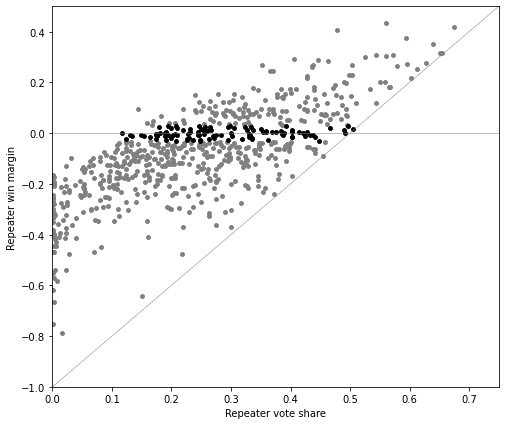

In [7]:
# Dibuja la figura con el tamaño especificado
plt.figure(figsize=(8, 7))  # Set the figure size

# Separa los puntos que están en el rango de -0.1 a 0.1 en y
mask = (dffg[f"diferencia_{año_t1}"] >= -0.03) & (dffg[f"diferencia_{año_t1}"] <= 0.03)
outside_range = dffg[~mask]
inside_range = dffg[mask]

# Puntos fuera del rango en gris
plt.scatter(outside_range[f"votos_porcentaje_{año_t1}"], outside_range[f"diferencia_{año_t1}"], alpha=1, color='grey', s = 15)
plt.scatter(inside_range[f"votos_porcentaje_{año_t1}"], inside_range[f"diferencia_{año_t1}"], alpha=1, color='black',  s = 15)

# Valores para la línea de y = -1 + 2x
x_vals = np.array([0, 1])
y_vals = -1 + 2 * x_vals
plt.plot(x_vals, y_vals, color='gray', linestyle='-', linewidth=0.5)
plt.xlabel("Repeater vote share")
plt.ylabel("Repeater win margin")

# Establece los límites de los ejes como se ha solicitado
plt.xlim(0, 0.75)
plt.ylim(-1, 0.5)
plt.axhline(0, color='gray', linewidth=0.5)

plt.savefig(f"{carpeta1}/vote_share_win_margin.png", dpi = 300)

### Base de dependientes y controles

In [488]:
variables = "INPUT_2_DATAMUNICIPAL"
dependientes = pd.read_csv(f"{variables}//dependientes.csv")
dependientes = dependientes[["codmpio", "date", "deuda_pc"]]
controles = pd.read_stata(f"{variables}//PANEL_CEDE_CONTROLES.dta")
controles = controles.rename(columns={"ano":"date"})

df = pd.merge(dependientes, dff, "inner", ["codmpio"])
df = pd.merge(df, controles, "inner", ["codmpio", "date"])

## Estimaciones

### Test de balanceo

In [12]:
año_control  = 2015

# List to hold results
results = []
# print(año_control-4, año_control)

for Y in df:
    
    # dfmedias = df[(df.date>=año_control-4) & (df.date<año_control)]
    dfmedias = df[(df.date>=año_control)]
    # dfmedias

    try:
        XT = dfmedias[dfmedias[f"diferencia_{año_t1}"] >= 0][Y].dropna()
        XN = dfmedias[dfmedias[f"diferencia_{año_t1}"] < 0][Y].dropna()

        mean_XT = XT.mean()
        mean_XN = XN.mean()
        diff_means = mean_XT - mean_XN

        t_stat, p_value = ttest_ind(XT, XN)

        results.append([Y, mean_XT, mean_XN, diff_means, p_value])

    except:
        None

# Convert results into a DataFrame
results_df = pd.DataFrame(results, columns=['Variable', 'Mean_XT', 'Mean_XN', 'Difference', 'P-value'])
results_df.to_excel(f"{carpeta1}/balanceo.xlsx")


### Prueba de densidad (McCrary)

In [17]:
from scipy.stats import norm

In [13]:
dfm = df[df.date == año_t1]
dfm = dfm[np.abs(dfm[f"diferencia_{año_t1}"])<abs(1)]
RV = dfm[f"diferencia_{año_t1}"].dropna()

In [21]:
rdd = rddensity.rddensity(X=RV)
DIF = round(rdd.hat["diff"],3)
EE = round(rdd.sd_jk["diff"],3)
Z = DIF/EE
PMCRARY = round(1 - norm.cdf(Z),3)

In [23]:
texto = f"Discontinuity est. = {DIF}, s.e. = {EE}, p = {PMCRARY}"

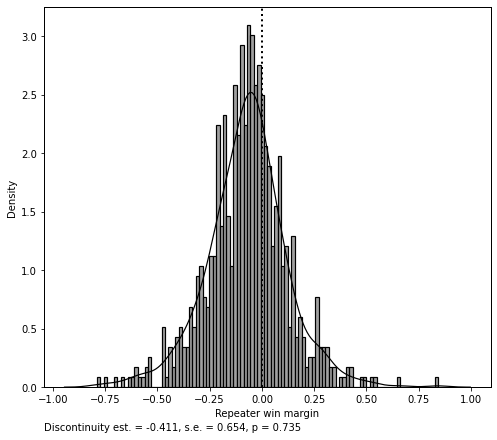

In [24]:
plt.figure(figsize=(8, 7))  # Set the figure size
plt.axvline(0, color='black', linestyle='dotted', linewidth=2)
sns.histplot(RV, bins=100, stat="density", color="gray", kde=False, edgecolor="black", linewidth = 1.2)
sns.kdeplot(RV, color="black", linewidth = 1.2)
plt.xlabel('Repeater win margin')
plt.ylabel('Density')
plt.grid(False)
spines_to_set = ['top', 'right', 'bottom', 'left']
for spine in spines_to_set:
    plt.gca().spines[spine].set_visible(True)
    plt.gca().spines[spine].set_linewidth(1)  # Establece el grosor de la línea
    plt.gca().spines[spine].set_edgecolor('black')  # Establece el color de la línea

plt.text(0, -0.12, texto, transform=plt.gca().transAxes, ha='left', va='bottom')

# plt.to_excel(f"{carpeta}/histogram")
plt.savefig(f"{carpeta1}/Mcrary.png", dpi = 300)

plt.show()




### Regresiones

Carpeta

In [28]:
carpeta2 = "OUT_4_RD_TABLES"
if not os.path.exists(carpeta2):
    os.makedirs(carpeta2)

Controles

In [29]:
lista_controles = list(controles.columns)

Organización base + parametros

In [490]:
d

,codmpio,date,deuda_pc,votos_porcentaje_2015,diferencia_2015,miembros_clean_2015,tipo_2015,ao_crea,gandina,gcaribe,...,indrural,areaoficialkm2,altura,discapital,DF_ahorro,s11_total,SGP_saludtot_per_capita,SGP_educaciontot_per_capita,X,Y
1,5001.0,2016.0,0.167876,0.001081,-0.164723,['PARTIDO LIBERAL COLOMBIANO'],PARTIDO,1675,1.0,0.0,...,0.011679,387.0,1475.0,0.000000,65.79,51.285599,81082.171875,258185.859375,-0.164723,0.167876
8,5002.0,2016.0,0.055678,0.219161,0.094037,['PARTIDO LIBERAL COLOMBIANO'],PARTIDO,1814,1.0,0.0,...,0.649700,497.0,2275.0,58.200874,42.47,50.881992,210723.171875,31607.478516,0.094037,0.055678
15,5021.0,2016.0,0.407032,0.381154,-0.162422,['PARTIDO CONSERVADOR COLOMBIANO'],PARTIDO,1907,1.0,0.0,...,0.473654,151.0,1750.0,61.114216,35.95,49.461952,247045.937500,32565.734375,-0.162422,0.407032
22,5030.0,2016.0,0.022969,0.079928,-0.108976,['PARTIDO SOCIAL DE UNIDAD NACIONAL - PARTIDO ...,PARTIDO,1912,1.0,0.0,...,0.429862,85.0,1400.0,29.878857,53.59,48.710781,121190.281250,27590.148438,-0.108976,0.022969
29,5034.0,2016.0,0.129315,0.249403,-0.032041,['PARTIDO CONSERVADOR COLOMBIANO'],PARTIDO,1853,1.0,0.0,...,0.502044,449.0,1350.0,76.310379,32.31,49.543304,193081.687500,30786.666016,-0.032041,0.129315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4978,95025.0,2016.0,0.000000,0.443694,0.109718,['PARTIDO SOCIAL DE UNIDAD NACIONAL - PARTIDO ...,PARTIDO,1992,0.0,0.0,...,0.483179,10434.0,200.0,67.893646,41.57,46.269138,154516.609375,33387.492188,0.109718,0.000000
4985,95200.0,2016.0,0.000000,0.193441,-0.008807,['PARTIDO LIBERAL COLOMBIANO'],PARTIDO,1992,0.0,0.0,...,0.758768,12914.0,200.0,124.022224,76.43,48.469982,138029.000000,14071.982422,-0.008807,0.000000
4992,99001.0,2016.0,0.000000,0.123838,-0.032781,['PARTIDO CAMBIO RADICAL COLOMBIANO'],PARTIDO,1953,0.0,0.0,...,0.157500,12409.0,51.0,0.000000,47.22,47.325886,303238.000000,55394.562500,-0.032781,0.000000
4999,99624.0,2016.0,0.000000,0.494872,0.068718,"['PARTIDO CAMBIO RADICAL COLOMBIANO', 'PARTIDO...",COALICION,1993,0.0,0.0,...,0.340775,2018.0,125.0,282.585205,35.92,49.868690,179247.296875,55354.527344,0.068718,0.000000


In [256]:
#PARAMETROS
# d["X"] = 1 + d[f"diferencia_{año_t1}"].copy()
# threshold = 1
# limite = 2

limite = 1
threshold = 0
año = año_t1+1
Y = "deuda_pc"

# d = df[(df.date >= año) & (df.date <= año+4)]
d = df[(df.date==año)]
d["X"] = d[f"diferencia_{año_t1}"].copy()
d["Y"] = d[Y]
dd = d[["Y", "X"]+lista_controles].dropna()
dd = dd[np.abs(dd["X"])<=limite]
dd['const'] = 1
dd["T"] = dd["X"].apply(lambda x: 1 if x>=threshold else 0)
dd['XT'] = dd['X'] * dd['T']

dd["Xa"] = np.abs(dd["X"].copy())
dd['XaT'] = dd['Xa'] * dd['T']

# dd = dd[dd["T"] ==1]
est1 = rdrobust(y=dd["Y"], x=dd["X"], p=1, deriv=1, kernel = "uniform", all = True, h = 100, vce='hc0',  c=threshold)
b_optimo = est1.bws.loc["b"][0]
# sm.OLS(dd['Y'], dd[['const', 'X', 'T', 'XT']]).fit().summaty()
# sm.OLS(dd['Y'], dd[['const', 'X', 'T', 'XT']]).fit(cov_type="HC3").summary2()
# A = sm.OLS(dd['Y'], dd[['const', 'X', 'T', 'XT']])
# A.fit?



In [33]:
dd["T"].sum()

227

In [38]:
# k = dd[dd["T"]==0]
# C = sm.OLS(k['Y'], k[['const', 'X']]).fit()
# C.summary()
# A = sm.OLS(dd['Y'], dd[['const', 'X', 'T', 'XT']]).fit()
# B = sm.OLS(dd['Y'], dd[['const', 'X', 'T', 'XA']]).fit()
# A.summary()
# B.summary()
# 0.1829-0.1854
# regresion_tablav2(B.summary2(), results, variables, round(b,3), 0)
# regresion_tablav1(A.summary2(), results, variables, round(b,3), 0)

In [34]:
# mserd, msetwo, msesum, msecomb1, msecomb2, cerrd, certwo, cersum, cercomb1, cercomb2

In [215]:
#FUNCIÓN PARA LA SIGNIFICANCIA

def significance(p_value):
    if p_value < 0.01:
        return '***'
    elif p_value < 0.05:
        return '**'
    elif p_value < 0.1:
        return '*'
    else:
        return ''

#FUNCIÓN PARA LA REGRESION

def regresion_tablav2(sumario, results, variables, bandwidth, media_dependiente):
    # Suponiendo que 'sumario' y 'results' son objetos ya definidos y accesibles

    # Extracción de datos
    N = sumario.tables[0].iloc[3,1]
    R = sumario.tables[0].iloc[6,1]

    # Creación y modificación de coef_df
    coef_df = sumario.tables[1][["Coef.", "Std.Err.","P>|t|"]]
    coef_df = coef_df.T[["const", "X", "T", "XT"]].T

    # Aplicar formato y agregar nuevas columnas
    coef_df['p'] = coef_df['P>|t|'].apply(significance)
    coef_df["coef"] = coef_df.apply(lambda row: f"{round(row['Coef.'], 3)}{row['p']}", axis=1)
    coef_df["std"] = coef_df["Std.Err."].round(3).apply(lambda x: f"({x})")

    # # Seleccionar y reordenar columnas
    coef_df = coef_df[["coef", "std"]].loc[["X", "T", "XT"]]

    # Reestructuración final del DataFrame
    coef_df = pd.DataFrame({"coef/std": coef_df.stack()}).reset_index(level=1, drop=True)

    coef_df.loc["e1"] = [""]
    coef_df.loc["e2"] = [""]
    coef_df.loc["Outcome mean"] = media_dependiente
    coef_df.loc["Bandwith"] = bandwidth
    coef_df.loc["R2"] = R
    coef_df.loc["Observations"] = N

    return coef_df

In [244]:
# dd["X2"] = dd["X"]**2
# dd["X3"] = dd["X"]**3

# dd["X2T"] = dd["X2"]*dd["T"]
# dd["X3T"] = dd["X3"]*dd["T"]

In [245]:
bandas = [1,1,b_optimo, b_optimo, b_optimo/2, b_optimo*2]
bandas = [1,1,b_optimo, b_optimo,  b_optimo,  b_optimo]
controles = [0,1,0,1,0,1]
dh = [0,0,0,0,1,1]

tabla_regresion = pd.DataFrame()

for b,c,d in zip(bandas, controles, dh):
    
    dr = dd.copy()
    # dr = dr[dr["Y"]>0]
    
    if b<1:
        if d==1:
            dr = dr[np.abs(dr["X"])>=b]

        else:
             dr = dr[np.abs(dr["X"])<=b]

    cont = []

    if c == 0:
        cont = []
    
    else:
        cont = lista_controles.copy()

    media = round(dr["Y"].mean(),3)

    model = sm.OLS(dr['Y'], dr[['const', 'X', 'T', 'XT']])
    # model = sm.OLS(dr['Y'], dr[['const', 'X', 'T', 'XT', 'X2','X3','X2T','X3T']+cont])
    results = model.fit()
    sumario = results.summary2()
    variables = list(sumario.tables[1].index)

    tabla = regresion_tablav2(sumario, results, variables, round(b,3), media)

    tabla_regresion = pd.concat([tabla_regresion, tabla], axis = 1)

In [246]:
tabla_regresion.to_excel(f"{carpeta2}/regresiones.xlsx")
tabla_regresion

,coef/std,coef/std,coef/std,coef/std,coef/std,coef/std
X,0.002,0.002,0.151,0.151,-0.003,-0.003
X,(0.061),(0.061),(0.183),(0.183),(0.124),(0.124)
T,-0.014,-0.014,0.002,0.002,-0.066,-0.066
T,(0.022),(0.022),(0.019),(0.019),(0.067),(0.067)
XT,0.366***,0.366***,-0.106,-0.106,0.541**,0.541**
XT,(0.114),(0.114),(0.295),(0.295),(0.24),(0.24)
e1,,,,,,
e2,,,,,,
Outcome mean,0.078,0.078,0.072,0.072,0.085,0.085
Bandwith,1,1,0.119,0.119,0.119,0.119


In [21]:
carpeta3 = "OUT_3_RD_GRAPHS"
if not os.path.exists(carpeta3):
    os.makedirs(carpeta3)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


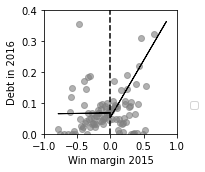

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


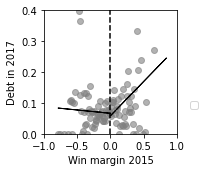

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


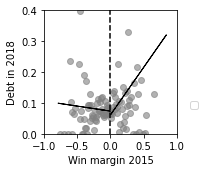

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


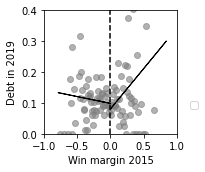

In [30]:
for año in años_ev[0:]:
    for Y in ["deuda_pc"]:
        try:
            threshold = 0

            d = df[df.date == año]
            d["X"] = d[f"diferencia_{año_t1}"].copy()
            d["Y"] = d[Y]
            dd = d[[Y, "X"]].dropna()
            dd.columns = ["Y", "X"]
            dd = dd[np.abs(dd["X"])<=1]


            #VERIFICAR QUE ES EL MISMO COEFICIENTE
            dd['const'] = 1
            dd["T"] = dd["X"].apply(lambda x: 1 if x>=threshold else 0)

            # Crear la interacción
            dd['XT'] = dd['X'] * dd['T']
            model = sm.OLS(dd['Y'], dd[['const', 'X', 'T', 'XT']])
            results = model.fit()
            sumario = results.summary2()

            #LO MISMO PERO CON EL COMANDO RD-ROBUST
            est1 = rdrobust(y=dd["Y"], x=dd["X"], p=1, deriv=1, kernel = "uniform", all = True, h = 100, vce='hc0')
            est2 = rdrobust(y=dd["Y"], x=dd["X"], p=1, deriv=1, kernel = "triangular", all = True, h = 100, vce = "hc0")

            N = sumario.tables[0].iloc[3,1]
            R = sumario.tables[0].iloc[6,1]

            coef_df = sumario.tables[1].loc[:,["Coef.", "P>|t|"]]
            coef_df['P>|t|'] = coef_df['P>|t|'].apply(significance)
            coef_df["coef"] = coef_df.apply(lambda row: str(round(row["Coef."],3))+row["P>|t|"], axis = 1)
            coef_df = coef_df[["coef"]]
            coef_df.loc["R"] = R
            coef_df.loc["N"] = N

            p = sumario.tables[1].loc["XT","P>|t|"]

            if p<0.1:

                maxy = dd["Y"].quantile(0.99)
                miny = dd["Y"].quantile(0.00)
            
                # Generar las predicciones del modelo
                dd['y_pred'] = results.predict(dd[['const', 'X', 'T', 'XT']])

                #########################################################################################################
                # Crear bines para X
                plt.figure(figsize=(3,2.5))  # Set the figure size

                bin_size = 0.01
                bins = np.arange(-1, 1 + bin_size, bin_size)
                dd['bin'] = pd.cut(dd['X'], bins, labels=(bins[:-1] + bin_size / 2), right=False)

                # Calcular la media de Y y de y_pred por bin
                # grouped = dd.groupby('bin').agg({'Y':'mean', 'y_pred':'mean'}).reset_index()
                grouped = dd.groupby('bin')[["Y", "y_pred"]].mean().reset_index()
                grouped['bin'] = grouped['bin'].astype(float)

                before_threshold = grouped[grouped['bin'] < threshold]
                after_threshold = grouped[grouped['bin'] >= threshold]

                # Graficar las medias de los datos reales por bin
                plt.scatter(before_threshold['bin'], before_threshold['Y'], color='gray', alpha=0.6)
                plt.scatter(after_threshold['bin'], after_threshold['Y'], color='gray', alpha=0.6)

                ##############################################################
                before_thresholdc = dd[dd['X'] < threshold]
                after_thresholdc = dd[dd['X'] >= threshold]

                # Graficar las medias de las predicciones por bin
                plt.plot(before_thresholdc['X'], before_thresholdc['y_pred'], color='black', linewidth=1)
                plt.plot(after_thresholdc['X'], after_thresholdc['y_pred'], color='black', linewidth=1)

                #########################################################################################################
                plt.axvline(x=threshold, color='black', linestyle='--')

                # Definir la posición inicial en la esquina superior derecha.
    
                # x_position = 1.1  # Justo a la derecha del eje
                # y_position = 0.95  # Cerca de la parte superior del eje
                # y_spacing = 0.05
                # for index, row in coef_df.iterrows():
                #     coef_string = f"{index}: {row['coef']}"
                    
                #     plt.annotate(coef_string, 
                #                 xy=(x_position, y_position), 
                #                 xycoords='axes fraction', 
                #                 fontsize=10,
                #                 horizontalalignment='left',
                #                 verticalalignment='center')

                #     # Mover la posición y hacia abajo para la siguiente entrada
                #     y_position -= y_spacing
                
                #########################################################################################################
                plt.xlabel(f"Win margin {año_t1}")
                # plt.ylabel(f"{Y} en {año}")
                plt.ylabel(f"Debt in {año}")
                plt.legend(loc=(1.1, 0.2))  # (0.75, 0.85) son coordenadas en fracciones del tamaño del gráfico.
                plt.xlim(-1,1)
                plt.ylim(0,0.4)
                # plt.gca().set_ylim(top=maxy)
                plt.tight_layout()
                plt.savefig(f"{carpeta3}//ELECCIONES_{año_t1}_{Y}_{año}", bbox_inches='tight', dpi = 300)
                plt.show()

        except Exception as e:
            print(f"Error encountered: {e}")
            traceback.print_exc()

            

## Robustez

### Placebo (variando tratamiento)

https://docs.iza.org/dp8282.pdf

https://github.com/ganong-noel/rdpermute/tree/master

In [ ]:
placebos =  []
vplacebos = []


np.random.seed(1820) 

for i in tqdm(range(0,1000)):

    placebos.append(i)
    ddp = dd.copy().reset_index(drop = True)
    ddp['Y'] = ddp['Y'].sample(frac=1).reset_index(drop=True)
    model = sm.OLS(ddp['Y'], ddp[['const', 'X', 'T', 'XT']+cont]).fit()
    sumario = model.summary2()
    coef_df = sumario.tables[1][["Coef.", "Std.Err.","P>|t|"]]
    coef_df = coef_df.T[["const", "X", "T", "XT"]]
    xt = coef_df.loc["Coef.", "XT"]
    vplacebos.append(xt)


placebos = pd.DataFrame(zip(placebos, vplacebos), columns = ["treshold", "XT"])    

min_coef = round(placebos.XT.min(),3)
max_coef = round(placebos.XT.max(),3)

results = []
NPLA = placebos.shape[0]
for i in np.arange(min_coef, max_coef, 0.01):
    prob = (placebos["XT"] <= i).sum() / NPLA
    results.append({"coef": i, "P<=coef": prob})
placebos_cdf = pd.DataFrame(results)

max_coef

100%|██████████| 1000/1000 [00:22<00:00, 43.78it/s]


0.745

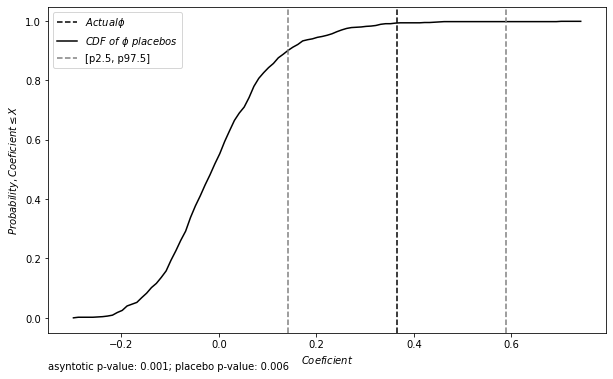

In [474]:
# Crear el line plot
plt.figure(figsize=(10, 6))  # Cambia el tamaño según necesites
modelp = sm.OLS(dd['Y'], dd[['const', 'X', 'T', 'XT']]).fit().summary2()

truec = modelp.tables[1][["Coef.", "[0.025", "0.975]"]].loc["XT"]["Coef."]
true_is = modelp.tables[1][["Coef.", "[0.025", "0.975]"]].loc["XT"]["0.975]"]
true_ii = modelp.tables[1][["Coef.", "[0.025", "0.975]"]].loc["XT"]["[0.025"]

pvalue_ols = round(modelp.tables[1][["Coef.", "[0.025", "0.975]", "P>|t|"]].loc["XT"]["P>|t|"],3)
pvalue_placebo = round(1 - ((placebos["XT"] <= truec).sum() / NPLA),3)

plt.axvline(x=truec, color='black', linestyle='--', label = r"$Actual \phi$")

plt.plot(placebos_cdf['coef'], placebos_cdf['P<=coef'], label=r"$CDF \ of \ \phi  \ placebos$", color ="black")

plt.axvline(x=true_ii, color='gray', linestyle='--', label = "[p2.5, p97.5]")
plt.axvline(x=true_is, color='gray', linestyle='--')

plt.xlabel(r'$Coeficient$')  # Etiqueta del eje X
plt.ylabel(r'$Probability,Coeficient \leq X$')  # Etiqueta del eje Y
# plt.title('Line Plot de placebos_cdf con Líneas Verticales')  # Título del gráfico
plt.legend()  # Muestra la leyenda

plt.text(0, -0.12, f'asyntotic p-value: {pvalue_ols}; placebo p-value: {pvalue_placebo}', transform=plt.gca().transAxes, ha='left', va='bottom')


# Mostrar el gráfico
plt.show()

### Placebo suponiendo los repitentes en 2011